In [1]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [3]:
raw_data_path = constants.PATH_TO_CORTEX_4_PARAMS_RAW
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = ['r1', 'tv', 'mt', 'r2s']

In [4]:
subjects_raw_data = DataProcessor(raw_data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

In [5]:
group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

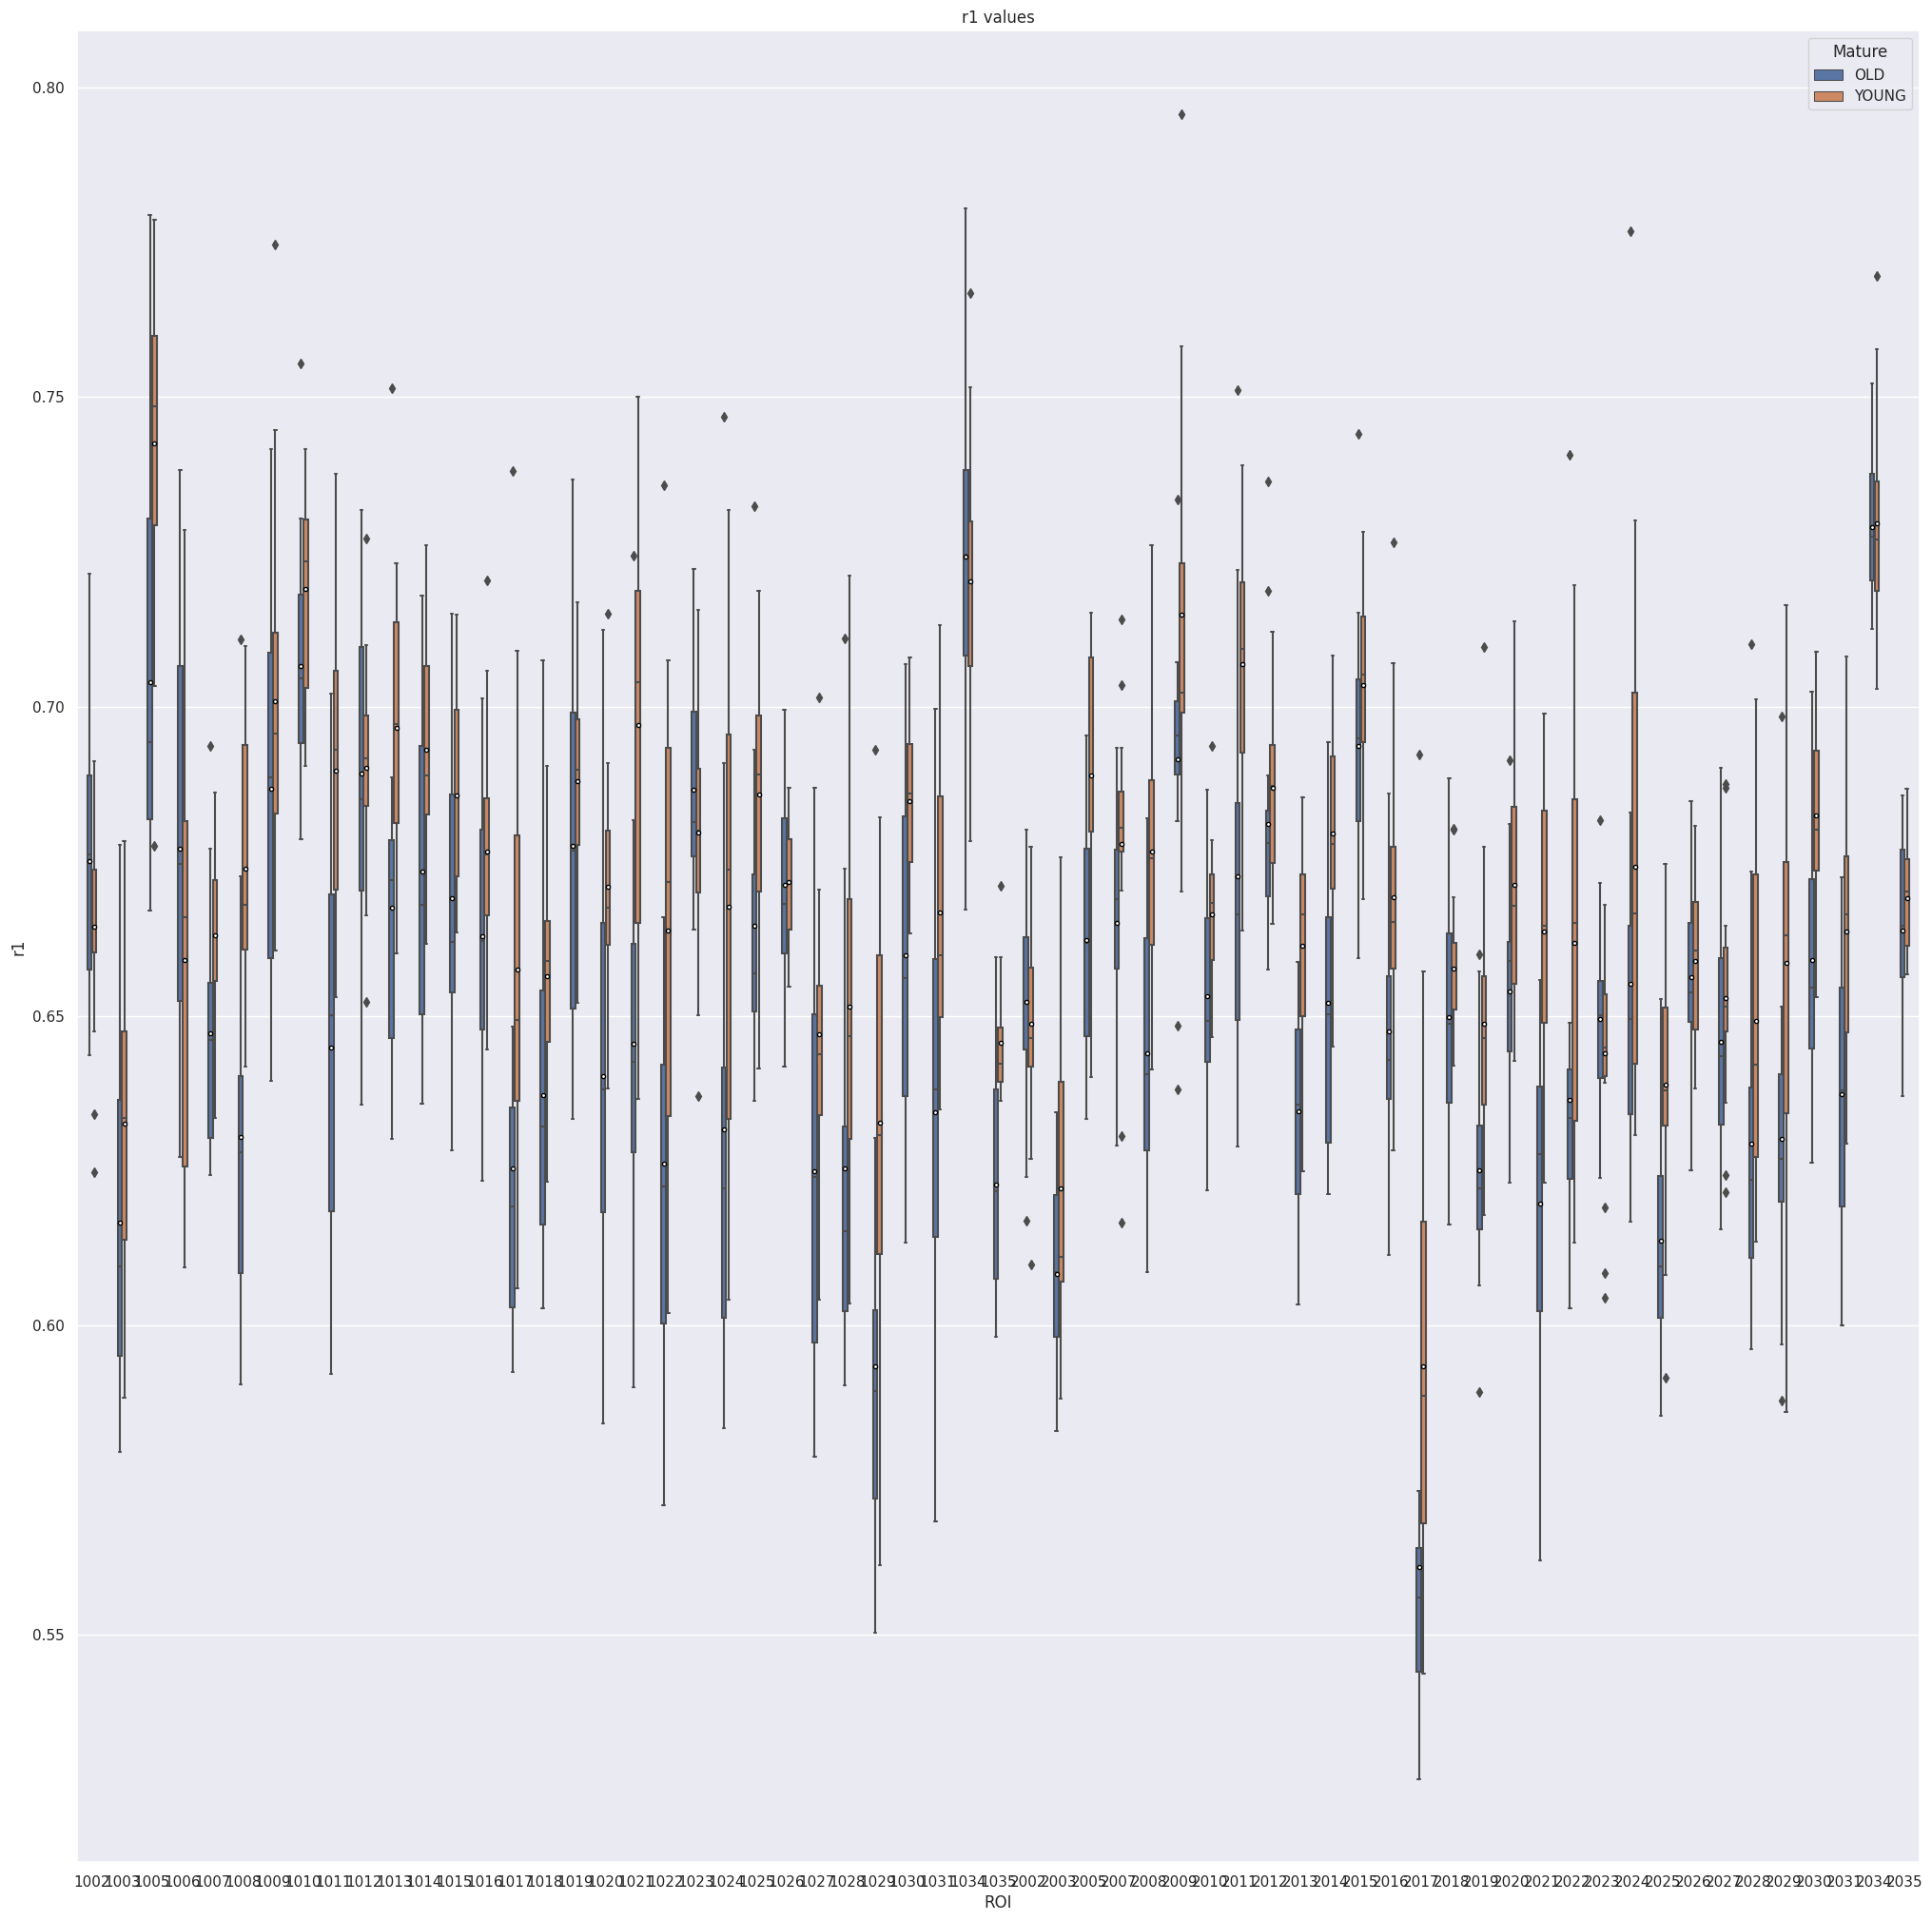

In [22]:
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects, old_subjects,
                                                                    ['r1'],
                                                                    group_a_name, group_b_name)

In [18]:
low_e = 0.03
hi_e = 0.06

q_low = chosen_data["r1"].quantile(0.01) - low_e
q_hi  = chosen_data["r1"].quantile(0.99) + hi_e

chosen_data_filterd = chosen_data[(chosen_data["r1"] > q_low) & (chosen_data["r1"] < q_hi)]

subjects_values_count = chosen_data_filterd['subjects'].value_counts()
mask = chosen_data_filterd['subjects'].map(subjects_values_count) == len(chosen_rois_dict.keys())
chosen_data_filterd = chosen_data_filterd[mask]

chosen_data_filterd.subjects.nunique()

33

In [19]:
young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data_filterd, col_divider, threshold)
print(f'young: {young_subjects.subjects.nunique()}, old: {old_subjects.subjects.nunique()}')

young: 18, old: 15


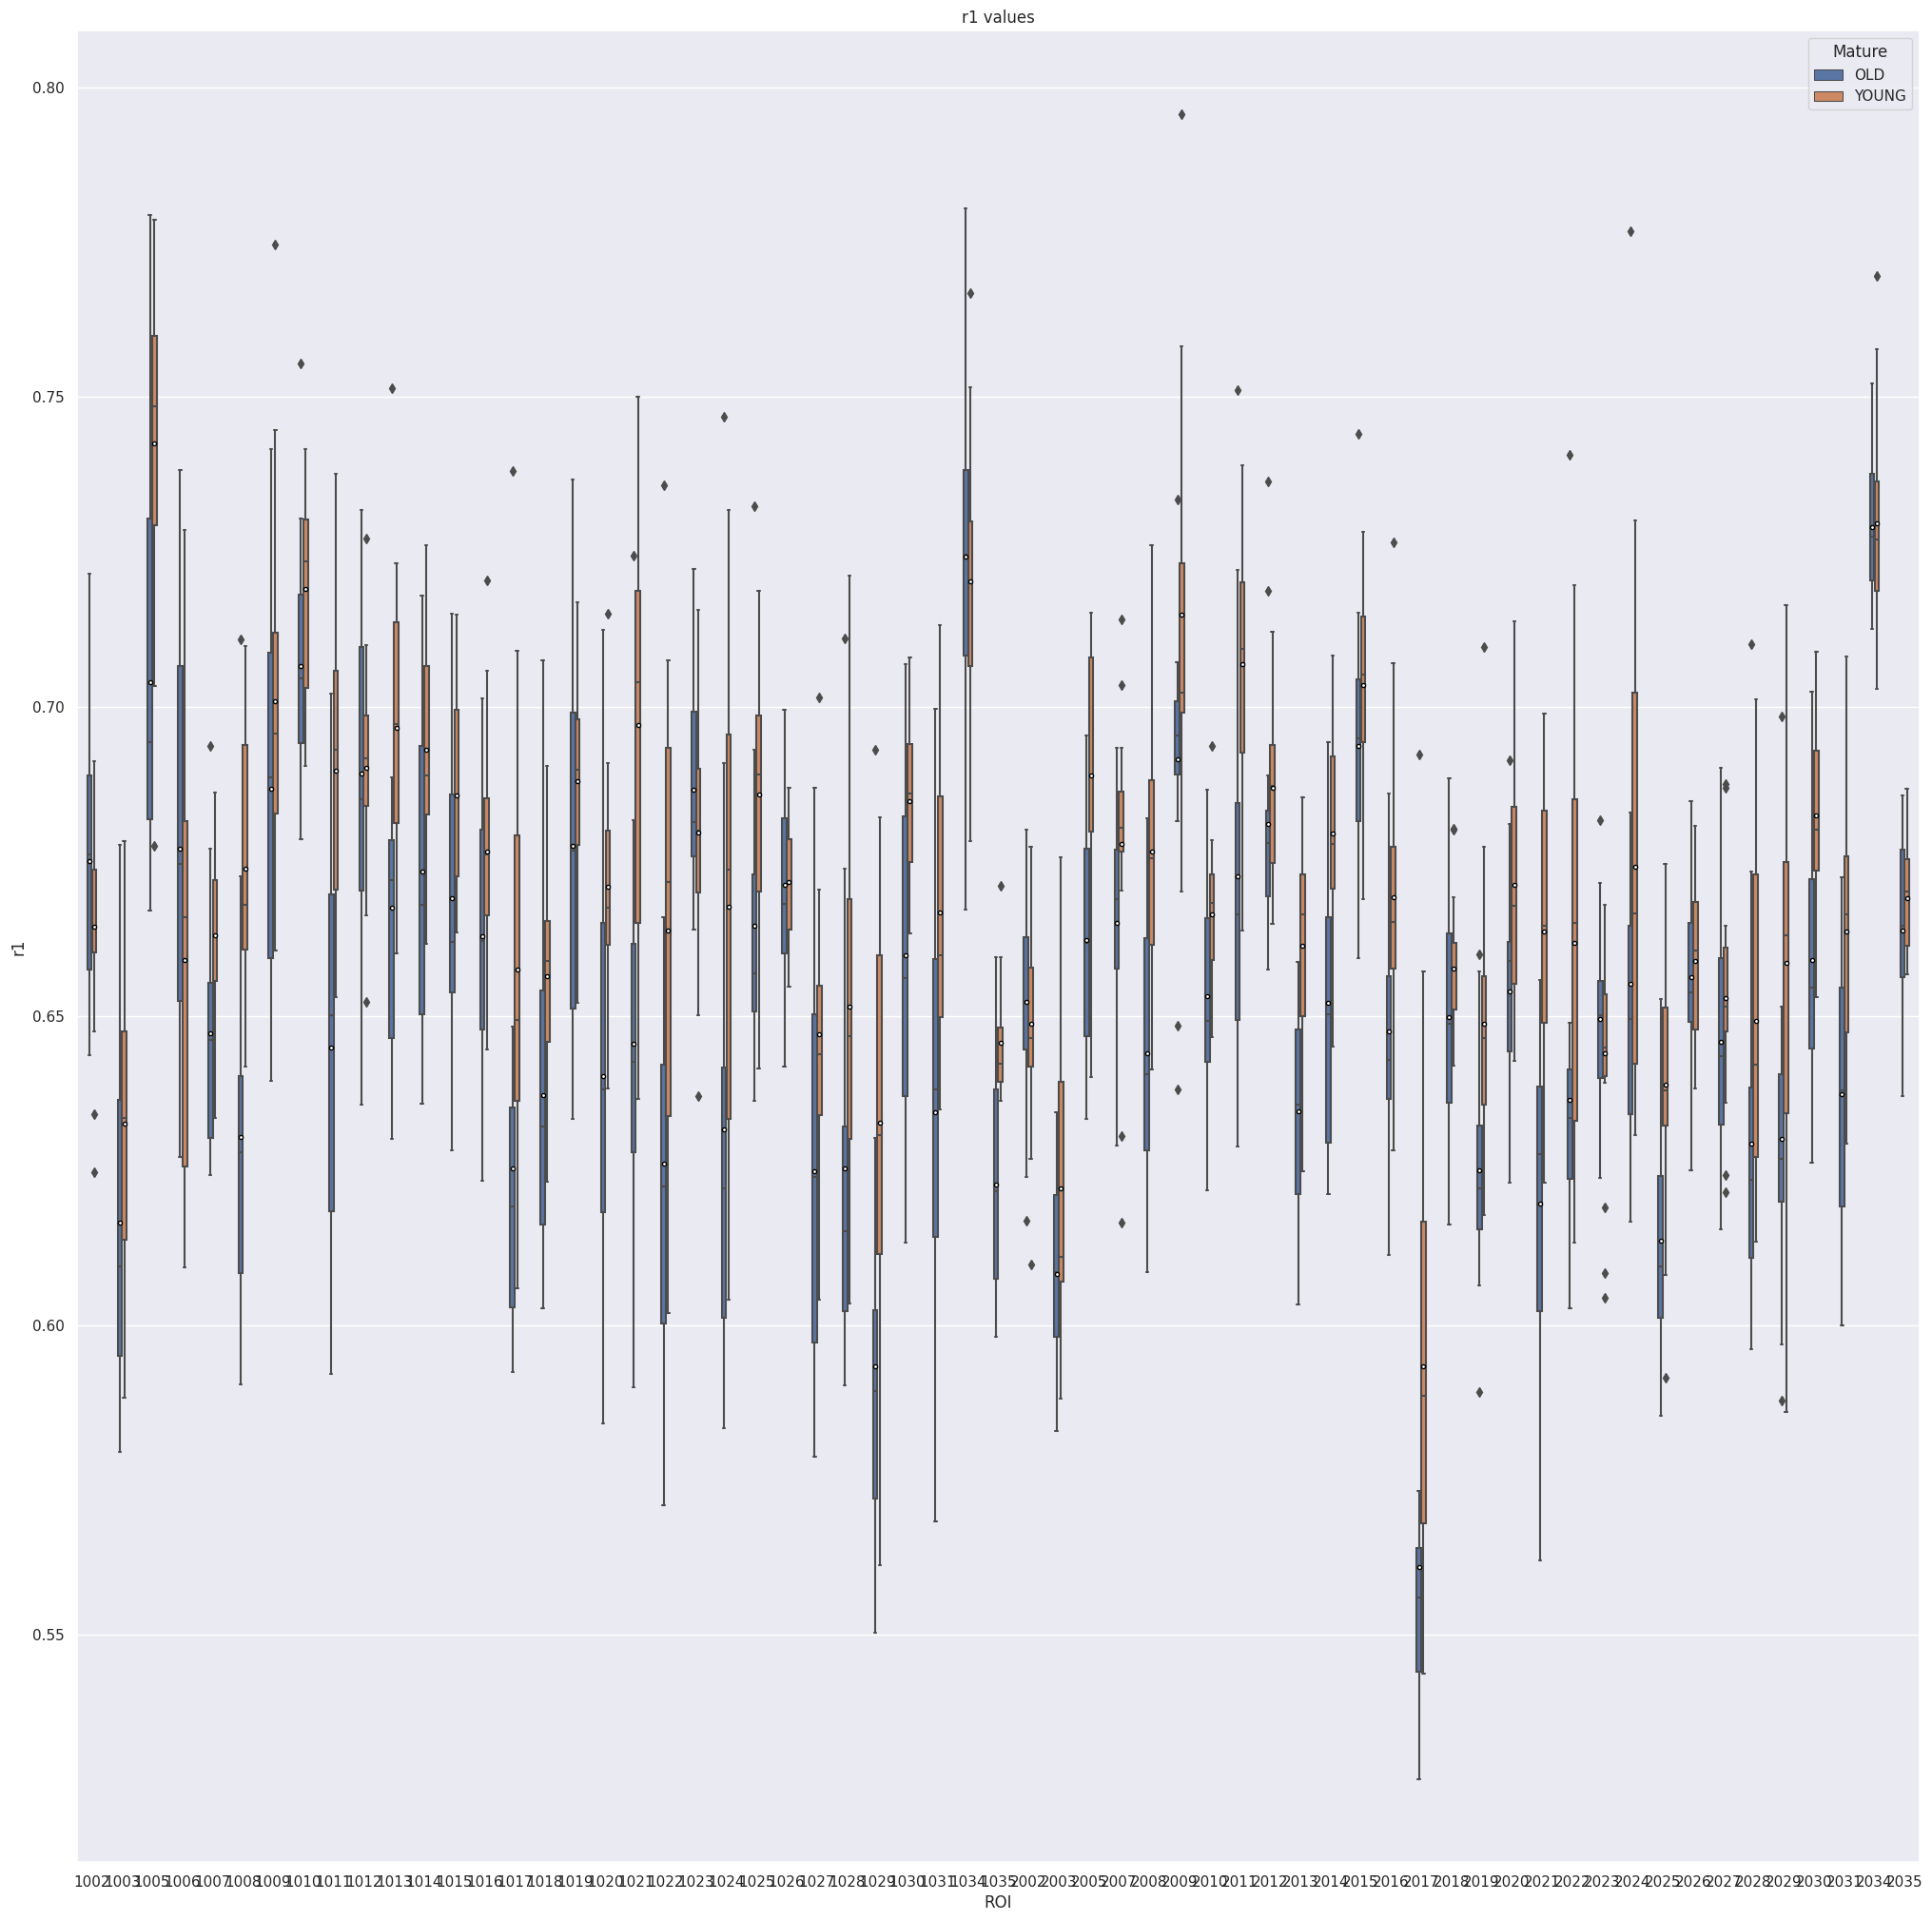

In [20]:
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects, old_subjects,
                                                                    ['r1'],
                                                                    group_a_name, group_b_name)

In [14]:
chosen_data["r1"] 

0       0.686899
1       0.613102
2       0.730644
3       0.674624
4       0.651634
          ...   
2313    0.683136
2314    0.666358
2315    0.680736
2316    0.721709
2317    0.687334
Name: r1, Length: 2318, dtype: float64

In [23]:
removed_df = chosen_data[(chosen_data["r1"] < q_low) | (chosen_data["r1"] > q_hi)]

subjects_values_count = removed_df['subjects'].value_counts()
mask = removed_df['subjects'].map(subjects_values_count) < len(chosen_rois_dict.keys())
removed_df = removed_df[mask]


In [8]:
outliers = removed_df.subjects.unique()
outliers

array(['H023_IN', 'H034_HB', 'H050_AB', 'H054_AE', 'H056_LE'],
      dtype=object)

In [111]:
data_path = os.path.join(constants.ANALYSIS_DIR, outliers[0])
seg_path = os.path.join(data_path, os.listdir(data_path)[0], constants.BASIC_SEG)
brain_path = os.path.join(data_path, os.listdir(data_path)[0], constants.MAP_R1)

In [112]:
os.system(f'freeview -v {brain_path} {seg_path}:colormap=lut &')

0

In [51]:
r1_data = subjects_raw_data[~subjects_raw_data['subjects'].isin(outliers)]
r1_data = np.concatenate(subjects_raw_data['r1'].values)
r1_data = pd.Series(r1_data)

In [52]:
r1_outliers_data = subjects_raw_data[subjects_raw_data['subjects'].isin(outliers)]
r1_outliers_data = np.concatenate(r1_outliers_data['r1'].values)
r1_outliers_data = pd.Series(r1_outliers_data)

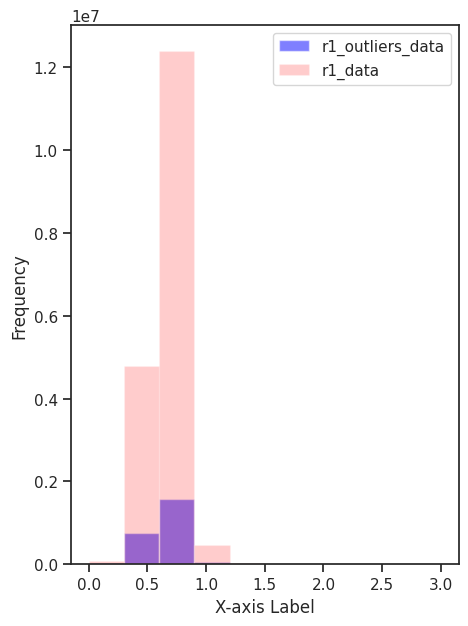

In [54]:
plt.figure(figsize=(5, 7))

plt.hist(r1_outliers_data, bins=10, range=[0, 3], color='blue', alpha=0.5, label='r1_outliers_data')
plt.hist(r1_data, bins=10, range=[0, 3], color='red', alpha=0.2, label='r1_data')
plt.xlabel('X-axis Label')
plt.ylabel('Frequency')
plt.legend()


In [12]:
subjects = chosen_data.groupby('subjects')
relevant_rois = list(chosen_data.ROI_name.unique())

def calculate_params_distances_of_subject(subject_df):
    df = subject_df['r1'].values
    dist = pdist(df.reshape(-1, 1), metric='euclidean')
    distance_matrix = pd.DataFrame(squareform(dist), index=relevant_rois, columns=relevant_rois)

    return distance_matrix


distances = subjects.apply(calculate_params_distances_of_subject)

In [18]:
subjects.get_group('H056_LE')

,subjects,ROI,r1,r2s,mt,tv,Slope-tv-r1,Dtv-r1-values,Slope-tv-r2s,Dtv-r2s-values,Age,Gender,ROI_name
2257,H056_LE,1002,0.690489,0.015323,0.015523,1.478437,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6904890084183699, 0.6904890084183699, 0.690...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0153228615581782, 0.0153228615581782, 0.015...",24,F,ctx-lh-caudalanteriorcingulate
2258,H056_LE,1003,0.661847,0.016411,0.012284,1.543024,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6618468018902416, 0.6618468018902416, 0.661...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01641121521070847, 0.01641121521070847, 0.0...",24,F,ctx-lh-caudalmiddlefrontal
2259,H056_LE,1005,0.738652,0.018588,0.015883,1.379460,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7386519197092588, 0.7386519197092588, 0.738...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.018588073568412446, 0.018588073568412446, 0...",24,F,ctx-lh-cuneus
2260,H056_LE,1006,0.731085,0.024443,0.015965,1.487265,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7302102386033003, 0.7302102386033003, 0.730...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024439635440398396, 0.024439635440398396, 0...",24,F,ctx-lh-entorhinal
2261,H056_LE,1007,0.650248,0.025420,0.014252,1.612021,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6502480716709123, 0.6502480716709123, 0.650...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.025420212440742683, 0.025420212440742683, 0...",24,F,ctx-lh-fusiform
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,H056_LE,2029,0.683136,0.016941,0.014013,1.505187,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.683136274759129, 0.683136274759129, 0.68313...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.016941059548768896, 0.016941059548768896, 0...",24,F,ctx-rh-superiorparietal
2314,H056_LE,2030,0.666358,0.016951,0.012995,1.564517,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6633483557331057, 0.6633483557331057, 0.663...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.016952199764034136, 0.016952199764034136, 0...",24,F,ctx-rh-superiortemporal
2315,H056_LE,2031,0.680736,0.016556,0.013741,1.495003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68073638315519, 0.68073638315519, 0.6807363...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.016555932563269118, 0.016555932563269118, 0...",24,F,ctx-rh-supramarginal
2316,H056_LE,2034,0.721709,0.017561,0.016310,1.417227,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7217085862408081, 0.7217085862408081, 0.721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01756057356207921, 0.01756057356207921, 0.0...",24,F,ctx-rh-transversetemporal


In [27]:
subjects = chosen_data.groupby('subjects')

def calculate_rois_distances(data):
    relevant_rois = set(data.ROI)
    symmetric_rois, other_rois = create_rois_pairs(relevant_rois)
    pass

def create_rois_pairs(rois):
    symmetric_rois = set()
    other_rois = set() 

    for roi in relevant_rois:
        for roi_to_match in rois:
            if roi == roi_to_match + 1000 or roi == roi_to_match - 1000:
                symmetric_rois.add(sorted((roi, roi_to_match)))
            elif roi != roi_to_match:
                other_rois.add(sorted((roi, roi_to_match)))


    return symmetric_rois, other_rois

subjects.apply(calculate_rois_distances)


TypeError: unhashable type: 'list'

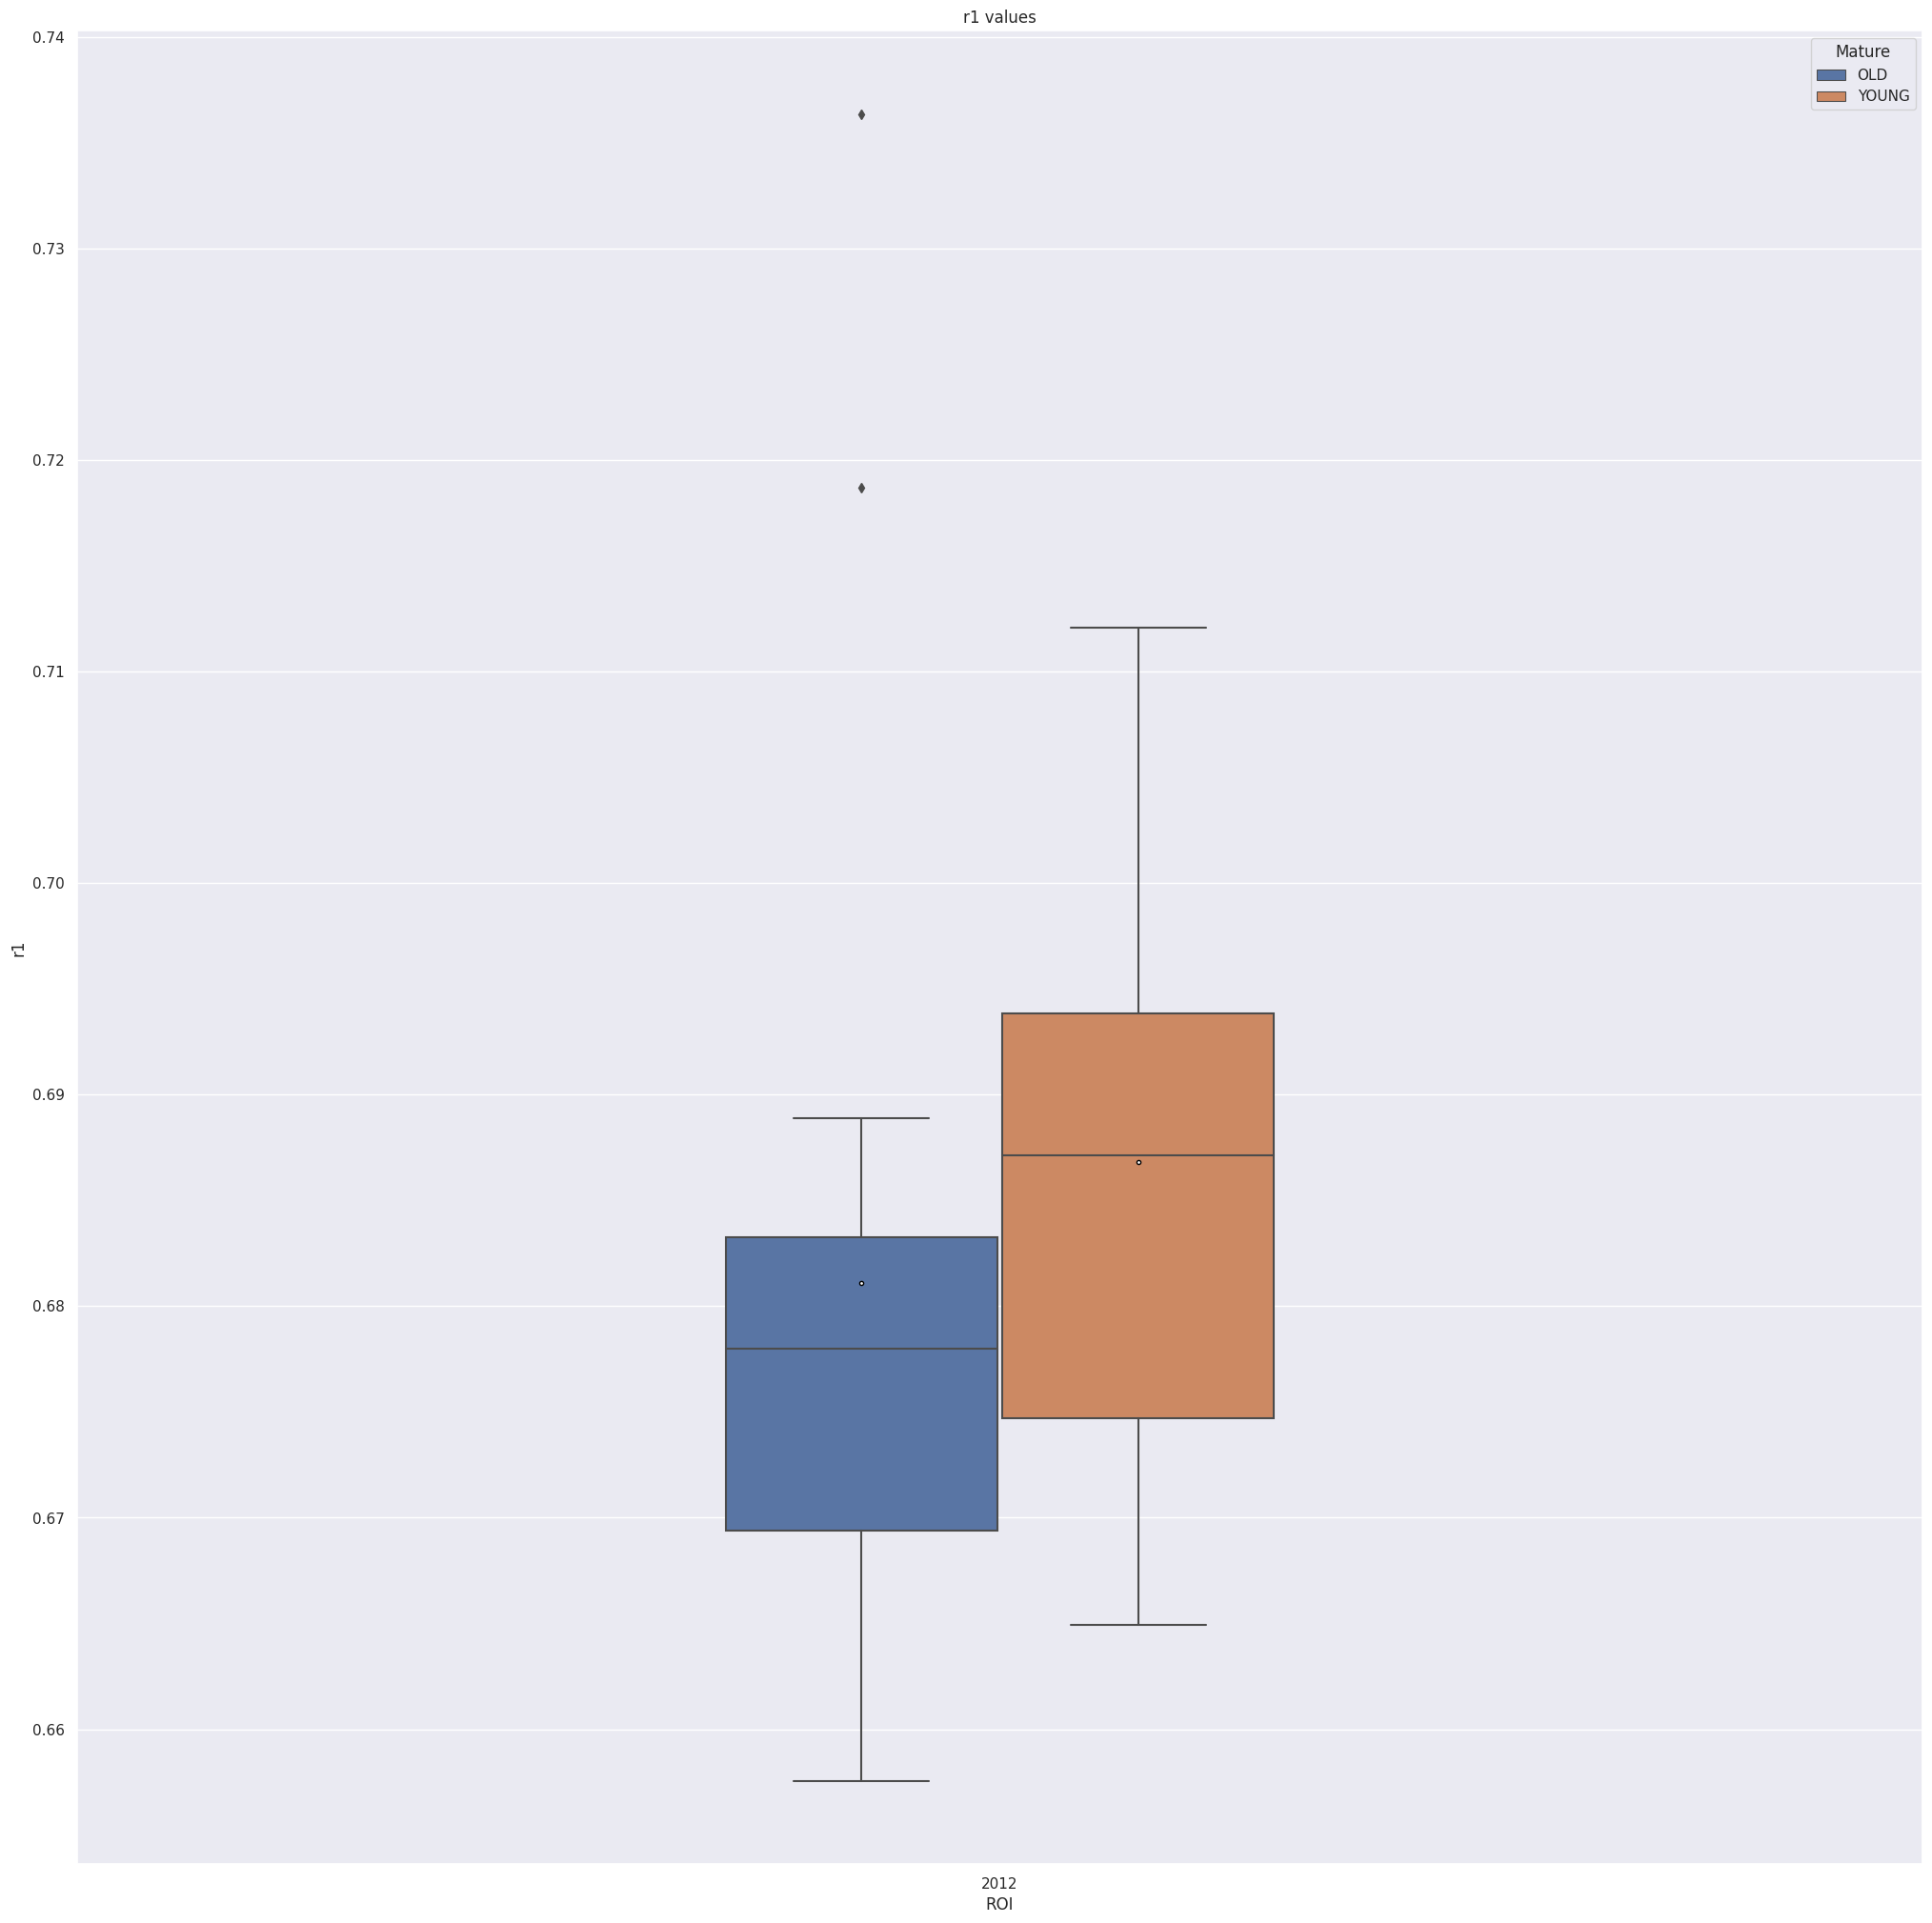

In [63]:
roi_to_see = 2012
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects[young_subjects.ROI == roi_to_see], old_subjects[old_subjects.ROI == roi_to_see],
                                                                    ['r1'],
                                                                    group_a_name, group_b_name)

In [64]:
roi_to_check_data = chosen_data[chosen_data.ROI == roi_to_see]

q_low = roi_to_check_data["r1"].quantile(0.01)
q_hi  = roi_to_check_data["r1"].quantile(0.99)

roi_to_check_data_filterd = roi_to_check_data[(roi_to_check_data["r1"] > q_low) & (roi_to_check_data["r1"] < q_hi)]
len(roi_to_check_data_filterd)

36

In [65]:
removed_df = roi_to_check_data[(roi_to_check_data["r1"] < q_low) | (roi_to_check_data["r1"] > q_hi)]
removed_df[['subjects', 'r1']]

,subjects,r1
771,H031_IN,0.736347
1930,H050_AB,0.625327


In [66]:
outliers = removed_df.subjects.unique()
outliers

array(['H031_IN', 'H050_AB'], dtype=object)

In [67]:
data_path = os.path.join(constants.ANALYSIS_DIR, outliers[0])
seg_path = os.path.join(data_path, os.listdir(data_path)[0], constants.BASIC_SEG)
brain_path = os.path.join(data_path, os.listdir(data_path)[0], constants.MAP_R1)

os.system(f'freeview -v {brain_path} {seg_path}:colormap=lut &')

0